In [ ]:
from google.colab import drive
 
drive.mount('/content/drive')
root = '/content/drive/My Drive/research/LDR pred'
 
import pandas as pd # load and manipulate data and for One-Hot Encoding
import numpy as np # calculate the mean and standard deviation
import xgboost as xgb # XGBoost stuff
import pickle # to save/load the model

from sklearn.model_selection import train_test_split # split  data into training and testing sets
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score, make_scorer, log_loss, brier_score_loss # for scoring during cross validation
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.model_selection import StratifiedKFold
#from tune_sklearn import TuneSearchCV

import sklearn.metrics
import os

from sklearn import metrics

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from matplotlib import pyplot
rcParams['figure.figsize'] = 12, 4

RAND_STATE = 30

rcParams['figure.facecolor'] = 'white'
rcParams['figure.dpi'] = 300.0

def Performance(Model,Y,X):
    rcParams['figure.figsize'] = 4, 4
    # Perforamnce of the model
    fpr, tpr, _ = roc_curve(Y, Model.predict_proba(X)[:,1])
    AUC  = metrics.auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='AUC = %0.4f' % AUC)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def ModelReport(_txt,_ytest,_ypred,_ypredprob):
  print(f"\n{'MODEL REPORT  -  '} {_txt}")
  print(f" {'Accuracy:':25} {metrics.accuracy_score(_ytest.values, _ypred):10.4f}")
  print(f" {'Precision:':25} {metrics.precision_score(_ytest.values, _ypred):10.4f}")
  print(f" {'Recall (sensitivity):':25} {metrics.recall_score(_ytest, _ypred):10.4f}")
  print(f" {'F1 Score:':25} {metrics.f1_score(_ytest.values, _ypred):10.4f}")
  print(f" {'AUC Score:':25} {metrics.roc_auc_score(_ytest.values, _ypredprob):10.4f}")
  print(f" {'Logloss:':25} {metrics.log_loss(_ytest.values, _ypredprob):10.4f}")
  print(f" {'Brier:':25} {metrics.brier_score_loss(_ytest.values, _ypredprob):10.4f}")


# eICU
df = pd.DataFrame(data=[]) # reset df 
df = pd.read_csv(f'{root}/eICU_all_ml.csv')

df = df.loc[(df['dr_uo'].notnull()) & ((df['FIV']==1) | (df['BIV']==1))].copy() # only keep days with IV loop diuretics

df = pd.concat([df.loc[:,:'dose'].fillna(0),
                df.loc[:,'dr_uo'],
                df.loc[:,'age':'ethnicity'],
                df.loc[:,'congestive_heart_failure':]], axis=1)

df['ethnicity'].replace({'African American':'Other', 'Hispanic':'Other', 'Asian':'Other', 'Native American':'Other',
                         'Other/Unknown':'Other'},inplace=True)
df.drop(columns={"Finf","Binf"},inplace=True)
df.rename(columns={"ethnicity": "ethn", "gender": "sex"}, inplace=True)
df = pd.get_dummies(df, columns=['sex','ethn'])

print('eICU data formatted')

# MIMIC
df_ = pd.read_csv(f'{root}/MIMIC_all_noimpute.csv')
df_ = df_[(df_['dr_uo'].isnull()==False) & ((df_['FIV']==1) | (df_['BIV']==1) | (df_['TIV']==1) )].copy() # only keep days with IV loop diuretics
df_ = pd.concat([df_.loc[:,'dr_uo'],
                df_.loc[:,'age':'ethn'],
                df_.loc[:,'congestive_heart_failure':'depression'], 
                df_.loc[:,'s_Na':]], axis=1) # gender + ethn + elixhauser + other diuretics + DDI + labs

df_['sex'].replace({1: 'female', 0: 'male'},inplace=True)
df_['ethn'].replace({0: 'Caucasian', 1: 'Other', 2: 'Other', 3:'Other', 4: 'Other', 5: 'Other', 6: 'Other'},inplace=True)

df_ = pd.get_dummies(df_, columns=['ethn','sex'])
print("finished mimic data prep")

Mounted at /content/drive
eICU data formatted
finished mimic data prep


In [ ]:
# Cols
## FOR XGB MODELS
cols_f1=['age', 'sex_female', 'ethn_Caucasian', 's_Cl', 's_K', 's_HCO3', 's_Cr', 's_Glu', 's_Ca', 's_Hct', 's_Plt', 's_WBC', 'avg_HR', 'avg_sBP', 'avg_RR', 'avg_TempC', 
      'avg_SpO2', 'congestive_heart_failure', 'diabetes_uncomplicated', 'renal_failure', 'liver_disease']

cols_accuracy=['age', 'sex_female', 'ethn_Caucasian', 's_Cl', 's_K', 's_HCO3', 's_Cr', 's_Glu', 's_Ca', 's_Hct', 's_Plt', 's_WBC', 'avg_HR', 'avg_sBP', 'avg_RR', 'avg_TempC', 
      'avg_SpO2', 'congestive_heart_failure', 'diabetes_uncomplicated', 'renal_failure', 'liver_disease']

cols_rando=['age', 'sex_female', 'ethn_Caucasian', 's_Cl', 's_K', 's_HCO3', 's_Cr', 's_Glu', 's_Ca', 's_Hgb', 's_Plt', 's_WBC', 'avg_HR', 'avg_sBP', 'avg_RR', 'avg_TempC', 
      'avg_SpO2', 'congestive_heart_failure', 'diabetes_uncomplicated', 'renal_failure', 'liver_disease']

cols_roc=['age', 'sex_female', 'ethn_Caucasian', 's_Cl', 's_K', 's_HCO3', 's_Cr', 's_Glu', 's_Ca', 's_Hct', 's_Plt', 's_WBC', 'avg_HR', 'avg_sBP', 'avg_RR', 'avg_TempC', 
      'avg_SpO2', 'congestive_heart_failure', 'diabetes_uncomplicated', 'renal_failure', 'liver_disease']


# load models
# XGB
xgb_f1 = pickle.load(open(f'{root}/xgb_f1_nan.pickle.dat', "rb"))
xgb_acc = pickle.load(open(f'{root}/xgb_acc_nan.pickle.dat', "rb"))
xgb_rando = pickle.load(open(f'{root}/xgb_ran_nan.pickle.dat', "rb"))
xgb_roc = pickle.load(open(f'{root}/xgb_roc_nan.pickle.dat', "rb"))


print('models loaded')

models loaded


In [ ]:
num_models = 4.0

# eICU (i.e.: train/test)
X_xgb_f1 = df.loc[:,cols_f1].copy()
X_xgb_acc = df.loc[:,cols_accuracy].copy() 
X_xgb_ran = df.loc[:,cols_rando].copy() 
X_xgb_roc = df.loc[:,cols_roc].copy() 
#X_rfc = df.loc[:,cols_rfc].copy()

y_test = df['dr_uo'].copy()

# MIMIC
X__xgb_f1 = df_.loc[:,cols_f1].copy()
X__xgb_acc = df_.loc[:,cols_accuracy].copy() 
X__xgb_ran = df_.loc[:,cols_rando].copy() 
X__xgb_roc = df_.loc[:,cols_roc].copy() 
#X__rfc = df_.loc[:,cols_rfc].copy()
y__test = df_['dr_uo'].copy()

print('xgb and rfc train/test datasets ready')

xgb and rfc train/test datasets ready


# eICU (train/test)

In [ ]:
# Train/test split
_ , X_xgb_f1_, _ , y_test_ = train_test_split(X_xgb_f1, y_test, test_size=0.20, random_state=RAND_STATE)
_ , X_xgb_acc_, _ , _ = train_test_split(X_xgb_acc, y_test, test_size=0.20, random_state=RAND_STATE)
_ , X_xgb_ran_, _ , _ = train_test_split(X_xgb_ran, y_test, test_size=0.20, random_state=RAND_STATE)
_ , X_xgb_roc_, _ , _ = train_test_split(X_xgb_roc, y_test, test_size=0.20, random_state=RAND_STATE)
#_ , X_rfc_ , _ , _ = train_test_split(X_rfc, y_test, test_size=0.20, random_state=RAND_STATE)
print("train/test sets ready")

train/test sets ready


In [ ]:
def adj_prob(y_pred, t):
  if t == 0.5: 
      return [y_pred][0]
  else: 
      return [0.4 if (y >= 0.5 and y < t) else y for y in y_pred]
# combine probabilities of different models

# remove "_" at end of each dataset to test all of eICU

# get probabilities from models
ypred_xgb_f1 = adj_prob(xgb_f1.predict_proba(X_xgb_f1)[:,1], t=0.5) # 0.5
ypred_xgb_acc = adj_prob(xgb_acc.predict_proba(X_xgb_acc)[:,1], t=0.5) # 0.8
ypred_xgb_ran = adj_prob(xgb_rando.predict_proba(X_xgb_ran)[:,1], t=0.5) # 0.9
ypred_xgb_roc = adj_prob(xgb_roc.predict_proba(X_xgb_roc)[:,1], t=0.5) # 0.6

#ypred_rfc_acc = adj_prob(rfc_acc.predict_proba(X_rfc_)[:,1], t=0.5)
#ypred_rfc_bri = adj_prob(rfc_brier.predict_proba(X_rfc_)[:,1], t=0.8)
#ypred_rfc_f1 = adj_prob(rfc_f1.predict_proba(X_rfc_)[:,1], t=0.5)
#ypred_rfc_roc = adj_prob(rfc_roc.predict_proba(X_rfc_)[:,1], t=0.5)


# average of the probabilities (arithmetic mean)
#ypredprob_arr_mean = [(aa+bb+cc+dd+ee+ff+gg+hh) / num_models for aa, bb, cc, dd, ee, ff, gg, hh in 
#                      zip(ypred_xgb_f1, ypred_xgb_acc, ypred_xgb_ran, ypred_xgb_roc,
#                          ypred_rfc_acc, ypred_rfc_bri, ypred_rfc_f1, ypred_rfc_roc)] 

# average of the probabilities (geometric mean) -> Power(1/n) of (x1*x2*...*xn)
#ypredprob_geo_mean = [(aa*bb*cc*dd*ee*ff*gg*hh)**(1/num_models) for aa, bb, cc, dd, ee, ff, gg, hh in 
#                      zip(ypred_xgb_f1, ypred_xgb_acc, ypred_xgb_ran, ypred_xgb_roc,
#                          ypred_rfc_acc, ypred_rfc_bri, ypred_rfc_f1, ypred_rfc_roc)]


# average of the probabilities (arithmetic mean)
ypredprob_arr_mean = [(aa+bb+cc+dd) / num_models for aa, bb, cc, dd in zip(ypred_xgb_f1, ypred_xgb_acc, ypred_xgb_ran, ypred_xgb_roc)]

# average of the probabilities (geometric mean) -> Power(1/n) of (x1*x2*...*xn)
ypredprob_geo_mean = [(aa*bb*cc*dd)**(1/num_models) for aa, bb, cc, dd in zip(ypred_xgb_f1, ypred_xgb_acc, ypred_xgb_ran, ypred_xgb_roc)]



# can consider using strong models twice, etc. to test different combinations

#print(f"{'   mod 1':10}{'   mod 2':10}{'   mod 3':10}{'   mod 4':10}{'   mod 5':10}{'   mod 6':10}{'   mod 7':10}{'   mod 8':10}{'   arr_avg':10}{'   geo_avg':10}")
print(f"{'   mod 1':10}{'   mod 2':10}{'   mod 3':10}{'   mod 4':10}{'   arr_avg':10}{'   geo_avg':10}")
for i in range(0,10):
  print(f"{ypred_xgb_f1[i]:10.4f}{ypred_xgb_acc[i]:10.4f}{ypred_xgb_ran[i]:10.4f}{ypred_xgb_roc[i]:10.4f}",
        #f"{ypred_rfc_acc[i]:10.4f}{ypred_rfc_bri[i]:10.4f}{ypred_rfc_f1[i]:10.4f}{ypred_rfc_roc[i]:10.4f}",
        f"{ypredprob_arr_mean[i]:10.4f}{ypredprob_geo_mean[i]:10.4f}")
  

   mod 1     mod 2     mod 3     mod 4     arr_avg   geo_avg
    0.6703    0.6806    0.7208    0.6823     0.6885    0.6882
    0.6417    0.5940    0.6290    0.6303     0.6237    0.6235
    0.5878    0.6212    0.4805    0.6587     0.5870    0.5831
    0.5121    0.5276    0.5391    0.4993     0.5195    0.5193
    0.8192    0.8192    0.8458    0.8324     0.8291    0.8291
    0.7895    0.8044    0.7961    0.8228     0.8032    0.8031
    0.8143    0.7941    0.7472    0.8229     0.7946    0.7940
    0.8373    0.7379    0.6880    0.8030     0.7665    0.7644
    0.6593    0.5885    0.5859    0.6997     0.6334    0.6315
    0.6632    0.6299    0.6132    0.6769     0.6458    0.6453


 Arr. Mean:

MODEL REPORT              
 Accuracy:                     0.6966
 Precision:                    0.7005
 Recall (sensitivity):         0.7320
 F1 Score:                     0.7159
 AUC Score:                    0.7696

                | Pred NoRes | Pred LDR  
True No Res     |       9701 |       5046
True LDR        |       4320 |      11801

Characteristics
  sens: 0.732027
  spec: 0.657829
   ppv: 0.700481
   npv: 0.691891
   LR+: 2.139357
   LR-: 0.407361


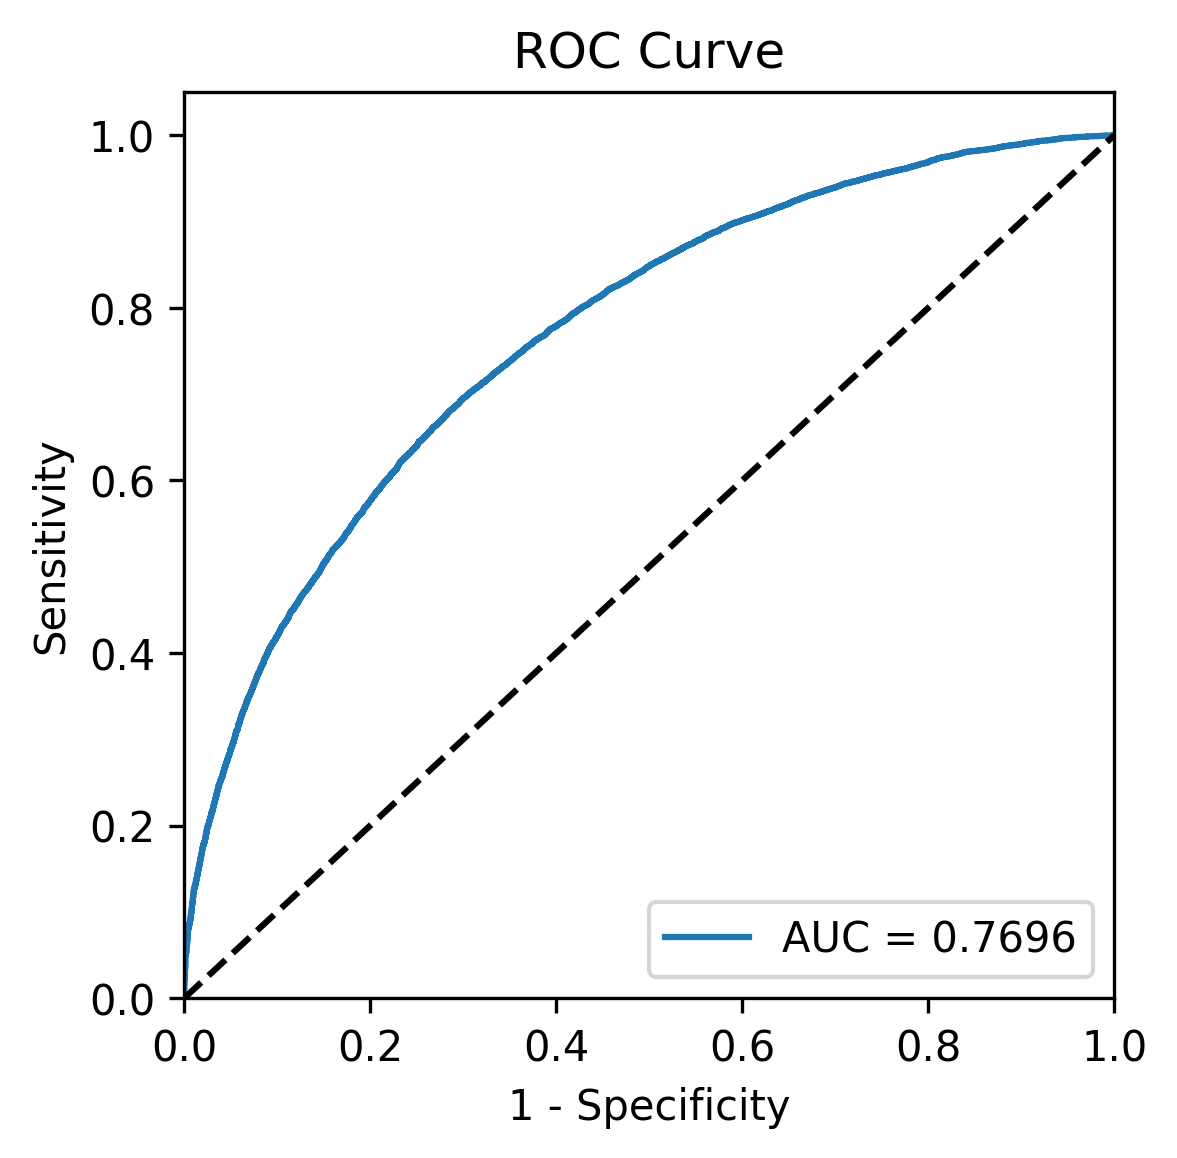


 Geo. Mean

MODEL REPORT              
 Accuracy:                     0.6968
 Precision:                    0.7019
 Recall (sensitivity):         0.7290
 F1 Score:                     0.7152
 AUC Score:                    0.7697

                | Pred NoRes | Pred LDR  
True No Res     |       9756 |       4991
True LDR        |       4369 |      11752

Characteristics
  sens: 0.728987
  spec: 0.661558
   ppv: 0.701905
   npv: 0.690690
   LR+: 2.153951
   LR-: 0.409658


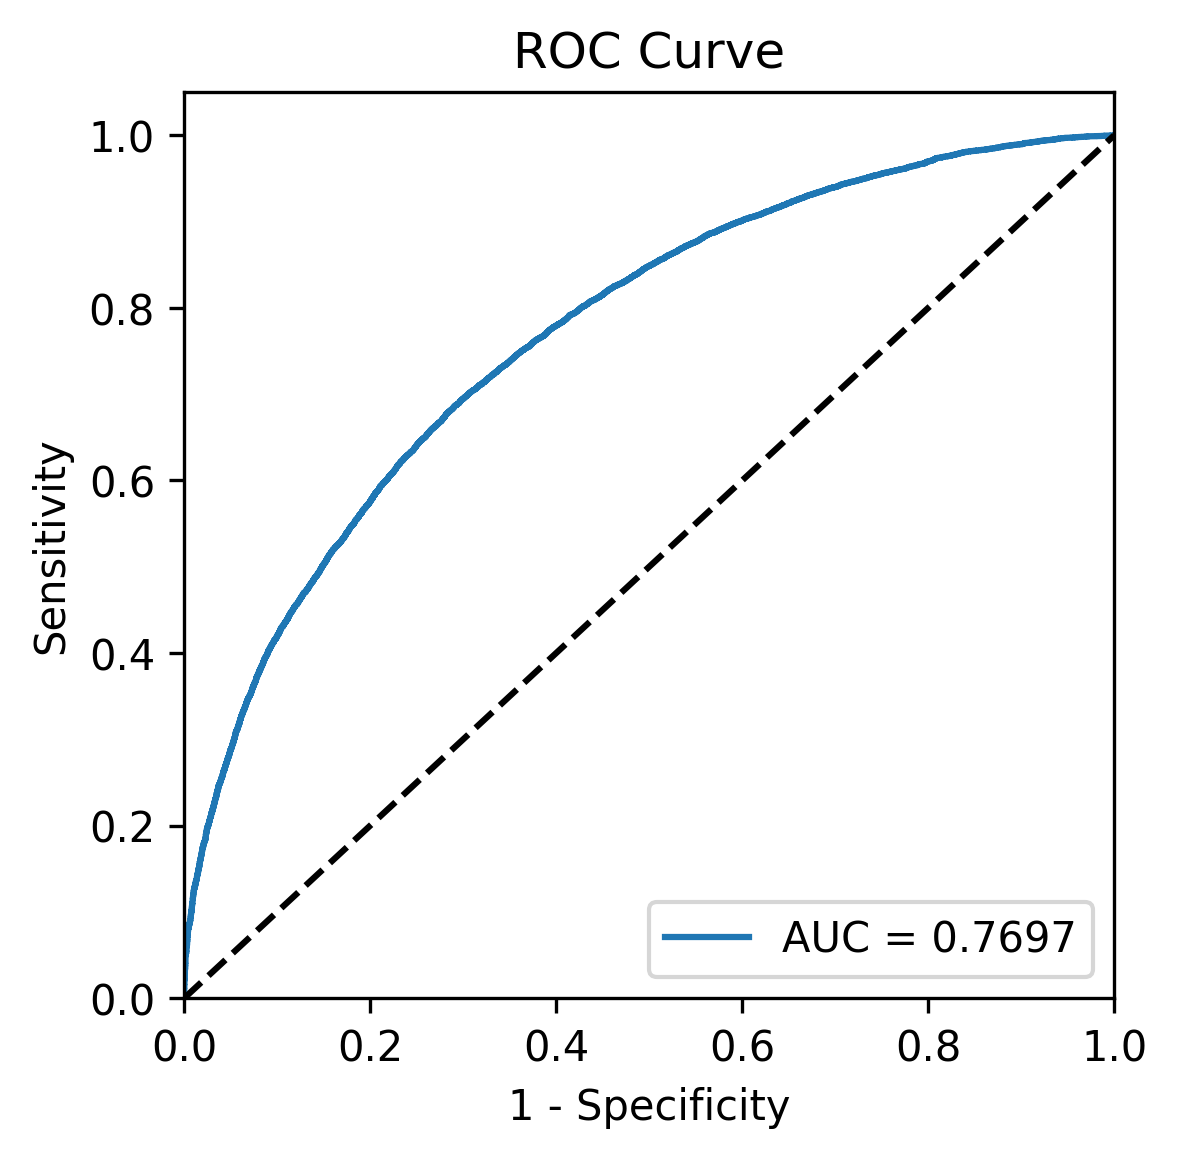

In [ ]:
# TO DO: create function with threshold for both models
# TO DO: create function that combines probabilities of both models (pre and post threshold)
# TO DO: test to see if adding more models improves outcomes (with variable thresholds)

# https://stats.stackexchange.com/questions/155817/combining-probabilities-information-from-different-sources

THRESH = 0.5

#y_test=[] # remove if testing all eICU
#y_test=y_test_.copy() # remove if testing all eICU

print(" Arr. Mean:")
#ypred, ypred_prob = [1 if y >= THRESH else 0 for y in ypredprob_arr_mean], ypredprob_arr_mean
ypred, ypred_prob = [1 if y >= THRESH else 0 for y in ypredprob_arr_mean], [0.49 if (y >= 0.5 and y < THRESH) else y for y in ypredprob_arr_mean]
        
#Print model report:
print(f"\n{'MODEL REPORT':26}")
print(f" {'Accuracy:':25} {metrics.accuracy_score(y_test.values, ypred):10.4f}")
print(f" {'Precision:':25} {metrics.precision_score(y_test.values, ypred):10.4f}")
print(f" {'Recall (sensitivity):':25} {metrics.recall_score(y_test, ypred):10.4f}")
print(f" {'F1 Score:':25} {metrics.f1_score(y_test.values, ypred):10.4f}")
print(f" {'AUC Score:':25} {metrics.roc_auc_score(y_test.values, ypred_prob):10.4f}")

#plot_confusion_matrix(xgb1, X__test, y__test, values_format='d', display_labels=["No Resistance", "Diuretic Resistance"])
cm = confusion_matrix(y_test, ypred) # get values to calculate sens/spec & LR's

print(f"\n{'':15} | {'Pred NoRes':10} | {'Pred LDR':10}")
print(f"{'True No Res':15} | {cm[0,0]:10} | {cm[0,1]:10}")
print(f"{'True LDR':15} | {cm[1,0]:10} | {cm[1,1]:10}")

sn = cm[1,1]/(cm[1,1]+cm[1,0]) # Sens = TP / (TP + FN)
sp = cm[0,0]/(cm[0,0]+cm[0,1]) # Spec = TN / (FP + TN)
ppv = cm[1,1]/(cm[1,1]+cm[0,1]) # PPV = TP / (TP + FP)
npv = cm[0,0]/(cm[0,0]+cm[1,0])# NPV = TN / (FN + TN)
pl = sn/(1-sp)
nl = (1-sn)/sp
print("\nCharacteristics")
print("  sens: %f" % sn)
print("  spec: %f" % sp)
print("   ppv: %f" % ppv)
print("   npv: %f" % npv)
print("   LR+: %f" % pl)
print("   LR-: %f" % nl)

rcParams['figure.figsize'] = 4, 4
    # Perforamnce of the model
fpr, tpr, _ = roc_curve(y_test.values, ypred_prob)
AUC  = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='AUC = %0.4f' % AUC)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


print("\n Geo. Mean")
#ypred, ypred_prob = [1 if y >= THRESH else 0 for y in ypredprob_geo_mean], ypredprob_geo_mean
ypred, ypred_prob = [1 if y >= THRESH else 0 for y in ypredprob_geo_mean], [0.49 if (y >= 0.5 and y < THRESH) else y for y in ypredprob_geo_mean]
        
#Print model report:
print(f"\n{'MODEL REPORT':26}")
print(f" {'Accuracy:':25} {metrics.accuracy_score(y_test.values, ypred):10.4f}")
print(f" {'Precision:':25} {metrics.precision_score(y_test.values, ypred):10.4f}")
print(f" {'Recall (sensitivity):':25} {metrics.recall_score(y_test, ypred):10.4f}")
print(f" {'F1 Score:':25} {metrics.f1_score(y_test.values, ypred):10.4f}")
print(f" {'AUC Score:':25} {metrics.roc_auc_score(y_test.values, ypred_prob):10.4f}")

#plot_confusion_matrix(xgb1, X__test, y__test, values_format='d', display_labels=["No Resistance", "Diuretic Resistance"])
cm = confusion_matrix(y_test, ypred) # get values to calculate sens/spec & LR's

print(f"\n{'':15} | {'Pred NoRes':10} | {'Pred LDR':10}")
print(f"{'True No Res':15} | {cm[0,0]:10} | {cm[0,1]:10}")
print(f"{'True LDR':15} | {cm[1,0]:10} | {cm[1,1]:10}")

sn = cm[1,1]/(cm[1,1]+cm[1,0]) # Sens = TP / (TP + FN)
sp = cm[0,0]/(cm[0,0]+cm[0,1]) # Spec = TN / (FP + TN)
ppv = cm[1,1]/(cm[1,1]+cm[0,1]) # PPV = TP / (TP + FP)
npv = cm[0,0]/(cm[0,0]+cm[1,0])# NPV = TN / (FN + TN)
pl = sn/(1-sp)
nl = (1-sn)/sp
print("\nCharacteristics")
print("  sens: %f" % sn)
print("  spec: %f" % sp)
print("   ppv: %f" % ppv)
print("   npv: %f" % npv)
print("   LR+: %f" % pl)
print("   LR-: %f" % nl)

rcParams['figure.figsize'] = 4, 4
    # Perforamnce of the model
fpr, tpr, _ = roc_curve(y_test.values, ypred_prob)
AUC  = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='AUC = %0.4f' % AUC)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

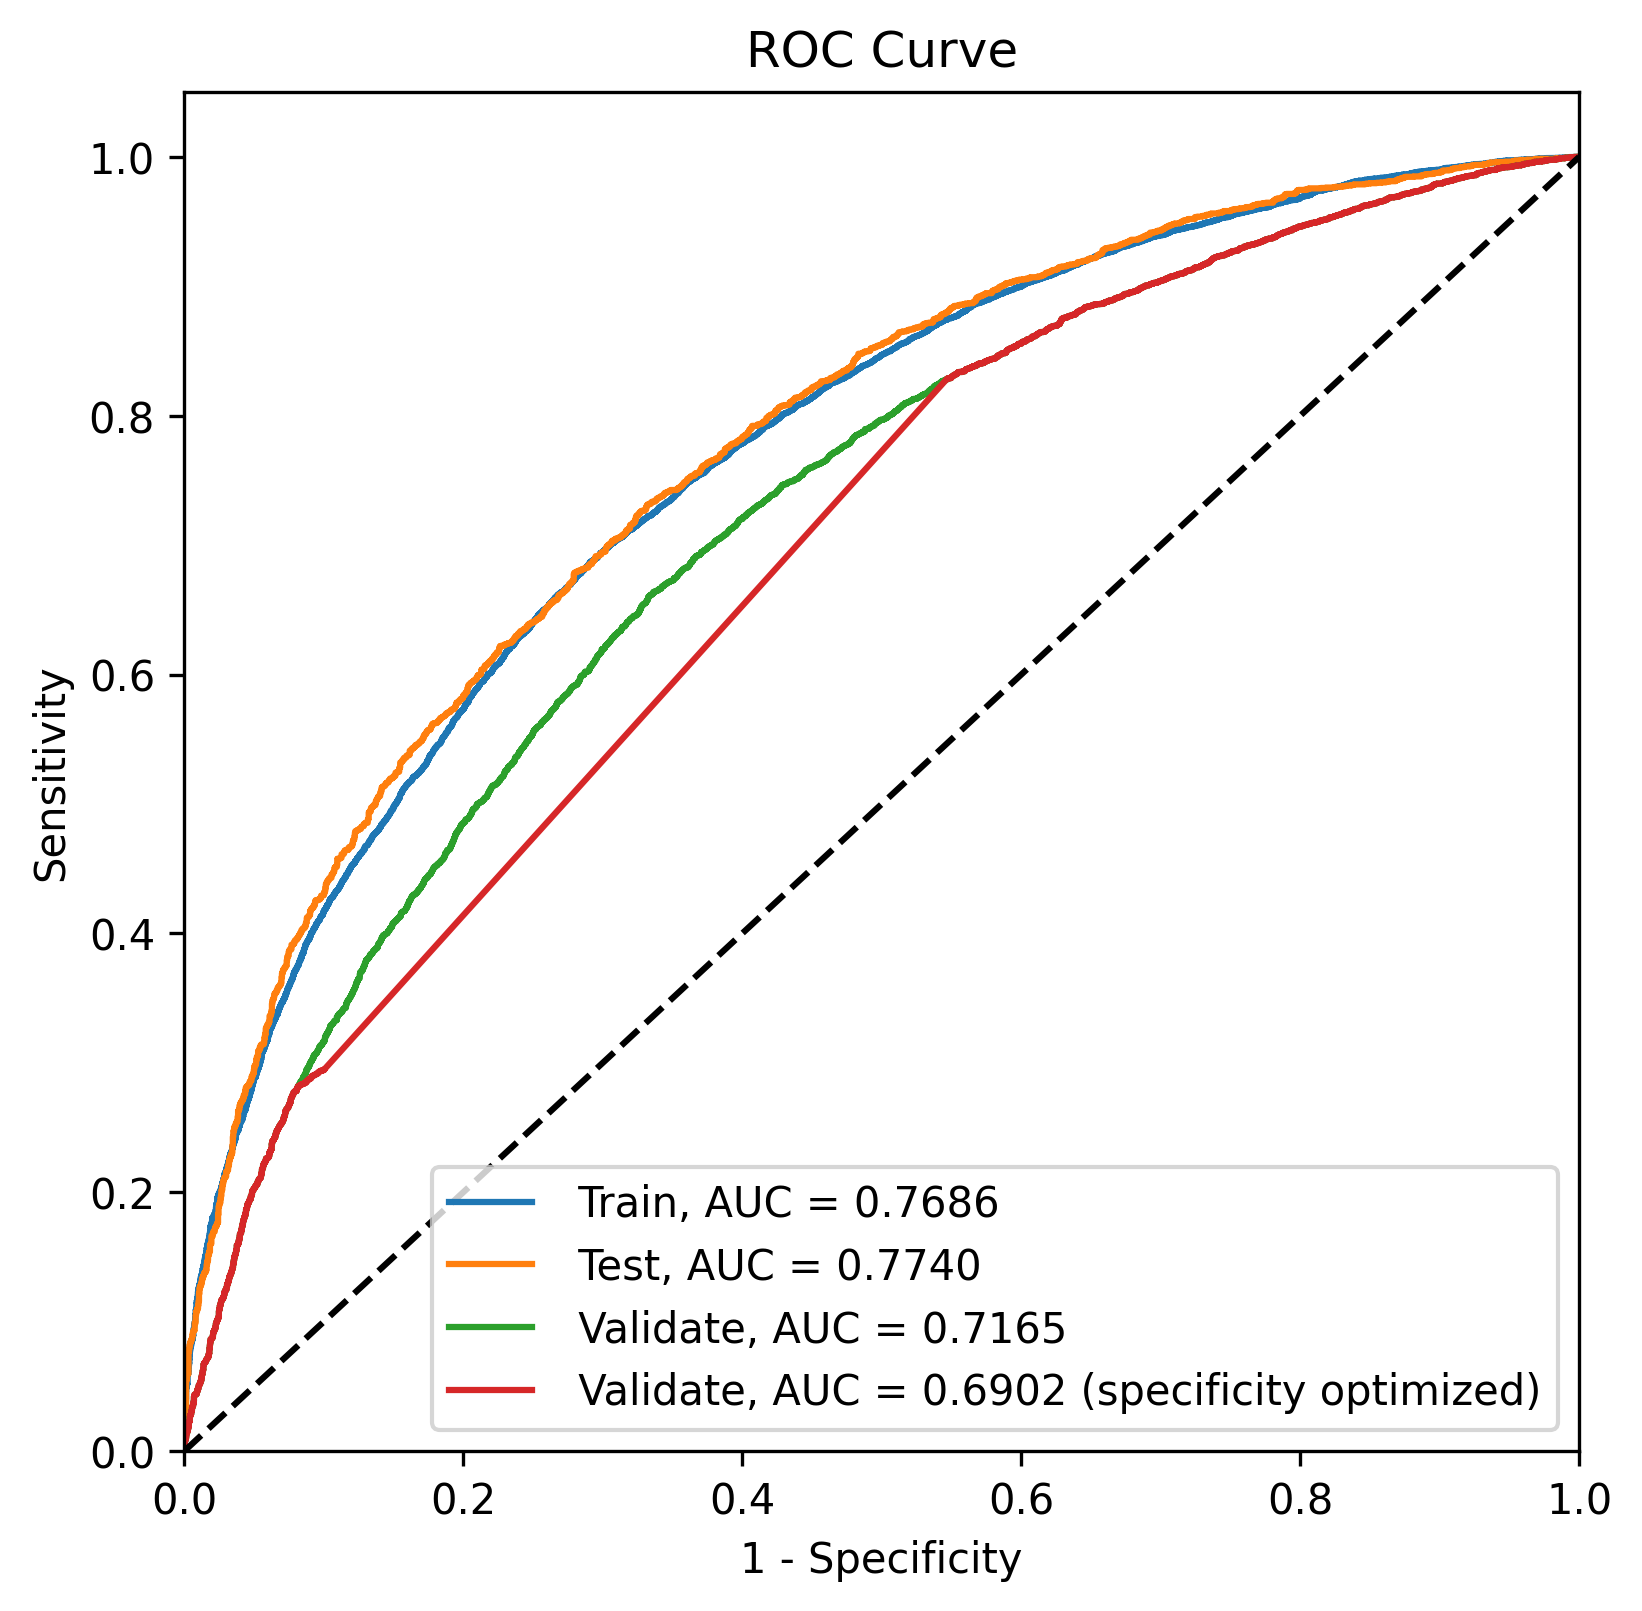


MODEL REPORT  -   Train
 Accuracy:                     0.6958
 Precision:                    0.7000
 Recall (sensitivity):         0.7287
 F1 Score:                     0.7141
 AUC Score:                    0.7686
 Logloss:                      0.5807
 Brier:                        0.1982

Characteristics, Train
  sens: 0.7287
  spec: 0.6598
   ppv: 0.7000
   npv: 0.6908
   LR+: 2.1423
   LR-: 0.4111



MODEL REPORT  -   Test
 Accuracy:                     0.7008
 Precision:                    0.7097
 Recall (sensitivity):         0.7300
 F1 Score:                     0.7197
 AUC Score:                    0.7740
 Logloss:                      0.5768
 Brier:                        0.1963

Characteristics, Test
  sens: 0.7300
  spec: 0.6685
   ppv: 0.7097
   npv: 0.6904
   LR+: 2.2020
   LR-: 0.4039



MODEL REPORT  -   Validate
 Accuracy:                     0.6440
 Precision:                    0.6083
 Recall (sensitivity):         0.8143
 F1 Score:                     0.6964
 AUC Sco

In [ ]:
# create individual ROC date for train and test (validate lower down)

# train test split
X_f1_train, X_f1_test, y_f1_train , y_f1_test = train_test_split(X_xgb_f1, y_test, test_size=0.20, random_state=RAND_STATE)
X_acc_train, X_acc_test, y_acc_train , y_acc_test = train_test_split(X_xgb_acc, y_test, test_size=0.20, random_state=RAND_STATE)
X_ran_train, X_ran_test, y_ran_train , y_ran_test = train_test_split(X_xgb_ran, y_test, test_size=0.20, random_state=RAND_STATE)
X_roc_train, X_roc_test, y_roc_train , y_roc_test = train_test_split(X_xgb_roc, y_test, test_size=0.20, random_state=RAND_STATE)

# train datasets;
ypred_xgb_f1_train = adj_prob(xgb_f1.predict_proba(X_f1_train)[:,1], t=0.5)
ypred_xgb_acc_train = adj_prob(xgb_acc.predict_proba(X_acc_train)[:,1], t=0.5)
ypred_xgb_ran_train = adj_prob(xgb_rando.predict_proba(X_ran_train)[:,1], t=0.5)
ypred_xgb_roc_train = adj_prob(xgb_roc.predict_proba(X_roc_train)[:,1], t=0.5)

# test datasets
ypred_xgb_f1_test = adj_prob(xgb_f1.predict_proba(X_f1_test)[:,1], t=0.5)
ypred_xgb_acc_test = adj_prob(xgb_acc.predict_proba(X_acc_test)[:,1], t=0.5)
ypred_xgb_ran_test = adj_prob(xgb_rando.predict_proba(X_ran_test)[:,1], t=0.5)
ypred_xgb_roc_test = adj_prob(xgb_roc.predict_proba(X_roc_test)[:,1], t=0.5)

# validate dataset
ypred_xgb_f1_val = adj_prob(xgb_f1.predict_proba(X__xgb_f1)[:,1], t=0.5)
ypred_xgb_acc_val = adj_prob(xgb_acc.predict_proba(X__xgb_acc)[:,1], t=0.5)
ypred_xgb_ran_val = adj_prob(xgb_rando.predict_proba(X__xgb_ran)[:,1], t=0.5)
ypred_xgb_roc_val = adj_prob(xgb_roc.predict_proba(X__xgb_roc)[:,1], t=0.5)

# geometric means
ypredprob_geo_mean_train = [(aa*bb*cc*dd)**(1/num_models) for aa, bb, cc, dd in zip(ypred_xgb_f1_train, ypred_xgb_acc_train, ypred_xgb_ran_train, ypred_xgb_roc_train)]
ypredprob_geo_mean_test = [(aa*bb*cc*dd)**(1/num_models) for aa, bb, cc, dd in zip(ypred_xgb_f1_test, ypred_xgb_acc_test, ypred_xgb_ran_test, ypred_xgb_roc_test)]
ypredprob_geo_mean_val = [(aa*bb*cc*dd)**(1/num_models) for aa, bb, cc, dd in zip(ypred_xgb_f1_val, ypred_xgb_acc_val, ypred_xgb_ran_val, ypred_xgb_roc_val)]
ypred_geo_train = [1 if y >= 0.5 else 0 for y in ypredprob_geo_mean_train]
ypred_geo_test = [1 if y >= 0.5 else 0 for y in ypredprob_geo_mean_test]
ypred_geo_val = [1 if y >= 0.5 else 0 for y in ypredprob_geo_mean_val]


# optimized for specificity
THRESH = 0.785
ypred_val_sp, ypred_prob_val_sp = [1 if y >= THRESH else 0 for y in ypredprob_geo_mean_val], [0.49 if (y >= 0.5 and y < THRESH) else y for y in ypredprob_geo_mean_val] 

# mark these as a comment if don't want to use the threshold
#ypred_geo_train, ypred_prob_geo_mean_train_threshold = [1 if y >= THRESH else 0 for y in ypredprob_geo_mean_train], [0.49 if (y >= 0.5 and y < THRESH) else y for y in ypredprob_geo_mean_train] 
#ypred_geo_test, ypred_prob_geo_mean_test_threshold = [1 if y >= THRESH else 0 for y in ypredprob_geo_mean_test], [0.49 if (y >= 0.5 and y < THRESH) else y for y in ypredprob_geo_mean_test] 


# generate AUROC
rcParams['figure.figsize'] = 6, 6
rcParams['figure.dpi'] = 300.0
rcParams['figure.facecolor'] = 'white'

fpr_train, tpr_train, _ = roc_curve(y_f1_train.values, ypredprob_geo_mean_train)
fpr_test, tpr_test, _ = roc_curve(y_f1_test.values, ypredprob_geo_mean_test)
fpr_val, tpr_val, _ = roc_curve(y__test.values, ypredprob_geo_mean_val)
fpr_valsp, tpr_valsp, _ = roc_curve(y__test.values, ypred_prob_val_sp)

# if want to use threshold for train/test (dont forget to comment the top):
#fpr_train, tpr_train, _ = roc_curve(y_f1_train.values, ypred_prob_geo_mean_train_threshold)
#fpr_test, tpr_test, _ = roc_curve(y_f1_test.values, ypred_prob_geo_mean_test_threshold)

AUC_train = metrics.auc(fpr_train, tpr_train)
AUC_test = metrics.auc(fpr_test, tpr_test)
AUC_val = metrics.auc(fpr_val, tpr_val)
AUC_valsp = metrics.auc(fpr_valsp, tpr_valsp)

plt.figure()
plt.plot(fpr_train, tpr_train, label= ' Train, AUC = %0.4f' % AUC_train)
plt.plot(fpr_test, tpr_test, label= ' Test, AUC = %0.4f' % AUC_test)
plt.plot(fpr_val, tpr_val, label= ' Validate, AUC = %0.4f' % AUC_val)
plt.plot(fpr_valsp, tpr_valsp, label= f" Validate, AUC = {AUC_valsp:0.4f} (specificity optimized)")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# stats
sn, sp, ppv, npv, pl, nl = [0 for i in range(4)] , [0 for i in range(4)], [0 for i in range(4)], [0 for i in range(4)], [0 for i in range(4)], [0 for i in range(4)]
for i in range(0,4): 
  if i == 0:
    txt = "Train"
    cm = confusion_matrix(y_f1_train, ypred_geo_train) 
    ModelReport(txt, y_f1_train, ypred_geo_train, ypredprob_geo_mean_train)
  if i == 1:
    txt = "Test"
    cm = confusion_matrix(y_f1_test, ypred_geo_test) 
    ModelReport(txt, y_f1_test, ypred_geo_test, ypredprob_geo_mean_test)
  if i == 2:
    txt = "Validate"
    cm = confusion_matrix(y__test, ypred_geo_val) 
    ModelReport(txt, y__test, ypred_geo_val, ypredprob_geo_mean_val)
  if i == 3:
    txt = "Validate (Spec optimized)"
    cm = confusion_matrix(y__test, ypred_val_sp) 
    ModelReport(txt, y__test, ypred_val_sp, ypred_prob_val_sp)
  
  sn[i] = cm[1,1]/(cm[1,1]+cm[1,0]) # Sens = TP / (TP + FN)
  sp[i] = cm[0,0]/(cm[0,0]+cm[0,1]) # Spec = TN / (FP + TN)
  ppv[i] = cm[1,1]/(cm[1,1]+cm[0,1]) # PPV = TP / (TP + FP)
  npv[i] = cm[0,0]/(cm[0,0]+cm[1,0])# NPV = TN / (FN + TN)
  pl[i] = sn[i]/(1-sp[i])
  nl[i] = (1-sn[i])/sp[i]

  print(f"\nCharacteristics, {txt}")
  print(f"  sens: {sn[i]:0.4f}")
  print(f"  spec: {sp[i]:0.4f}")
  print(f"   ppv: {ppv[i]:0.4f}")
  print(f"   npv: {npv[i]:0.4f}")
  print(f"   LR+: {pl[i]:0.4f}")
  print(f"   LR-: {nl[i]:0.4f}")
  print(f"\n")
  

In [ ]:
txt = "Train"
cm = confusion_matrix(y_f1_train, ypred_geo_train) 
  
sn = cm[1,1]/(cm[1,1]+cm[1,0]) # Sens = TP / (TP + FN)
sp = cm[0,0]/(cm[0,0]+cm[0,1]) # Spec = TN / (FP + TN)
ppv = cm[1,1]/(cm[1,1]+cm[0,1]) # PPV = TP / (TP + FP)
npv = cm[0,0]/(cm[0,0]+cm[1,0])# NPV = TN / (FN + TN)
pl = sn/(1-sp)
nl = (1-sn)/sp

print(f"\nCharacteristics, {txt}")
print(f"  sens: {sn:0.4f}")
print(f"  spec: {sp:0.4f}")
print(f"   ppv: {ppv:0.4f}")
print(f"   npv: {npv:0.4f}")
print(f"   LR+: {pl:0.4f}")
print(f"   LR-: {nl:0.4f}")

SyntaxError: ignored

# Feature Importance, partial depedence, SHAP etc

In [ ]:
! pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 26.8 MB/s 


In [ ]:
X_model = xgb_f1
X_full = X_xgb_f1
#X_sampled = X_xgb_f1_

# MODELS
# xgb_f1 = pickle.load(open(f'{root}/xgb_f1.pickle.dat', "rb"))
# xgb_acc = pickle.load(open(f'{root}/xgb_accuracy.pickle.dat', "rb"))
# xgb_rando = pickle.load(open(f'{root}/xgb_rando.pickle.dat', "rb"))
# xgb_roc = pickle.load(open(f'{root}/xgb_roc.pickle.dat', "rb"))

# eICU (i.e.: train/test) - ENTIRE DATASET
# X_xgb_f1 = df.loc[:,cols_f1].copy()
# X_xgb_acc = df.loc[:,cols_accuracy].copy() 
# X_xgb_ran = df.loc[:,cols_rando].copy() 
# X_xgb_roc = df.loc[:,cols_roc].copy()

# TRAIN/TEST
# _ , X_xgb_f1_, _ , y_test_ = train_test_split(X_xgb_f1, y_test, test_size=0.20, random_state=RAND_STATE)
# _ , X_xgb_acc_, _ , _ = train_test_split(X_xgb_acc, y_test, test_size=0.20, random_state=RAND_STATE)
# _ , X_xgb_ran_, _ , _ = train_test_split(X_xgb_ran, y_test, test_size=0.20, random_state=RAND_STATE)
# _ , X_xgb_roc_, _ , _ = train_test_split(X_xgb_roc, y_test, test_size=0.20, random_state=RAND_STATE)

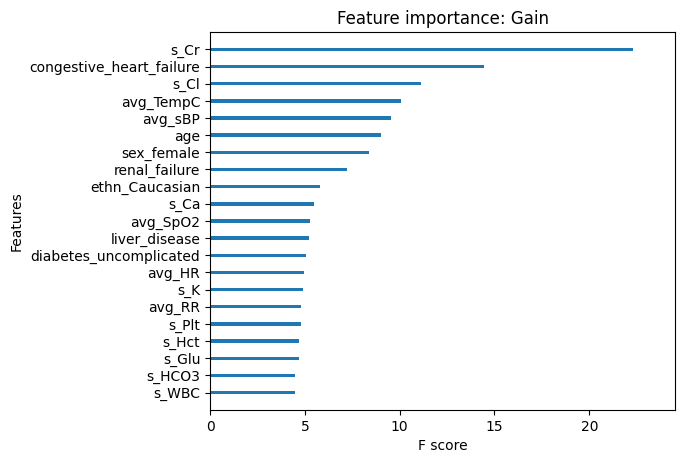

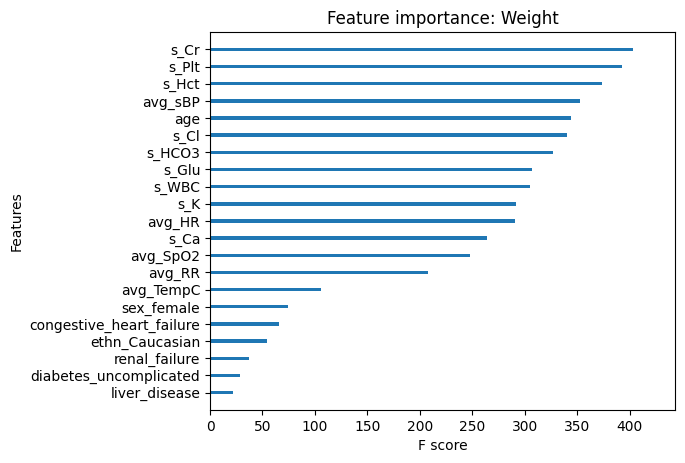

In [ ]:
# xgboost.plot_importance(booster, ax=None, height=0.2, xlim=None, ylim=None, 
# title='Feature importance', xlabel='F score', ylabel='Features', fmap='', 
# importance_type='weight', max_num_features=None, grid=True, show_values=True, **kwargs)

# discussion of feature importance score
# https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

rcParams['figure.figsize'] = 6, 5
rcParams['figure.dpi'] = 100.0
rcParams['figure.facecolor'] = 'white'

xgb.plot_importance(X_model, title='Feature importance: Gain', grid=False,
                    importance_type='gain', show_values=False)

xgb.plot_importance(X_model, title='Feature importance: Weight', grid=False,
                    importance_type='weight', show_values=False)

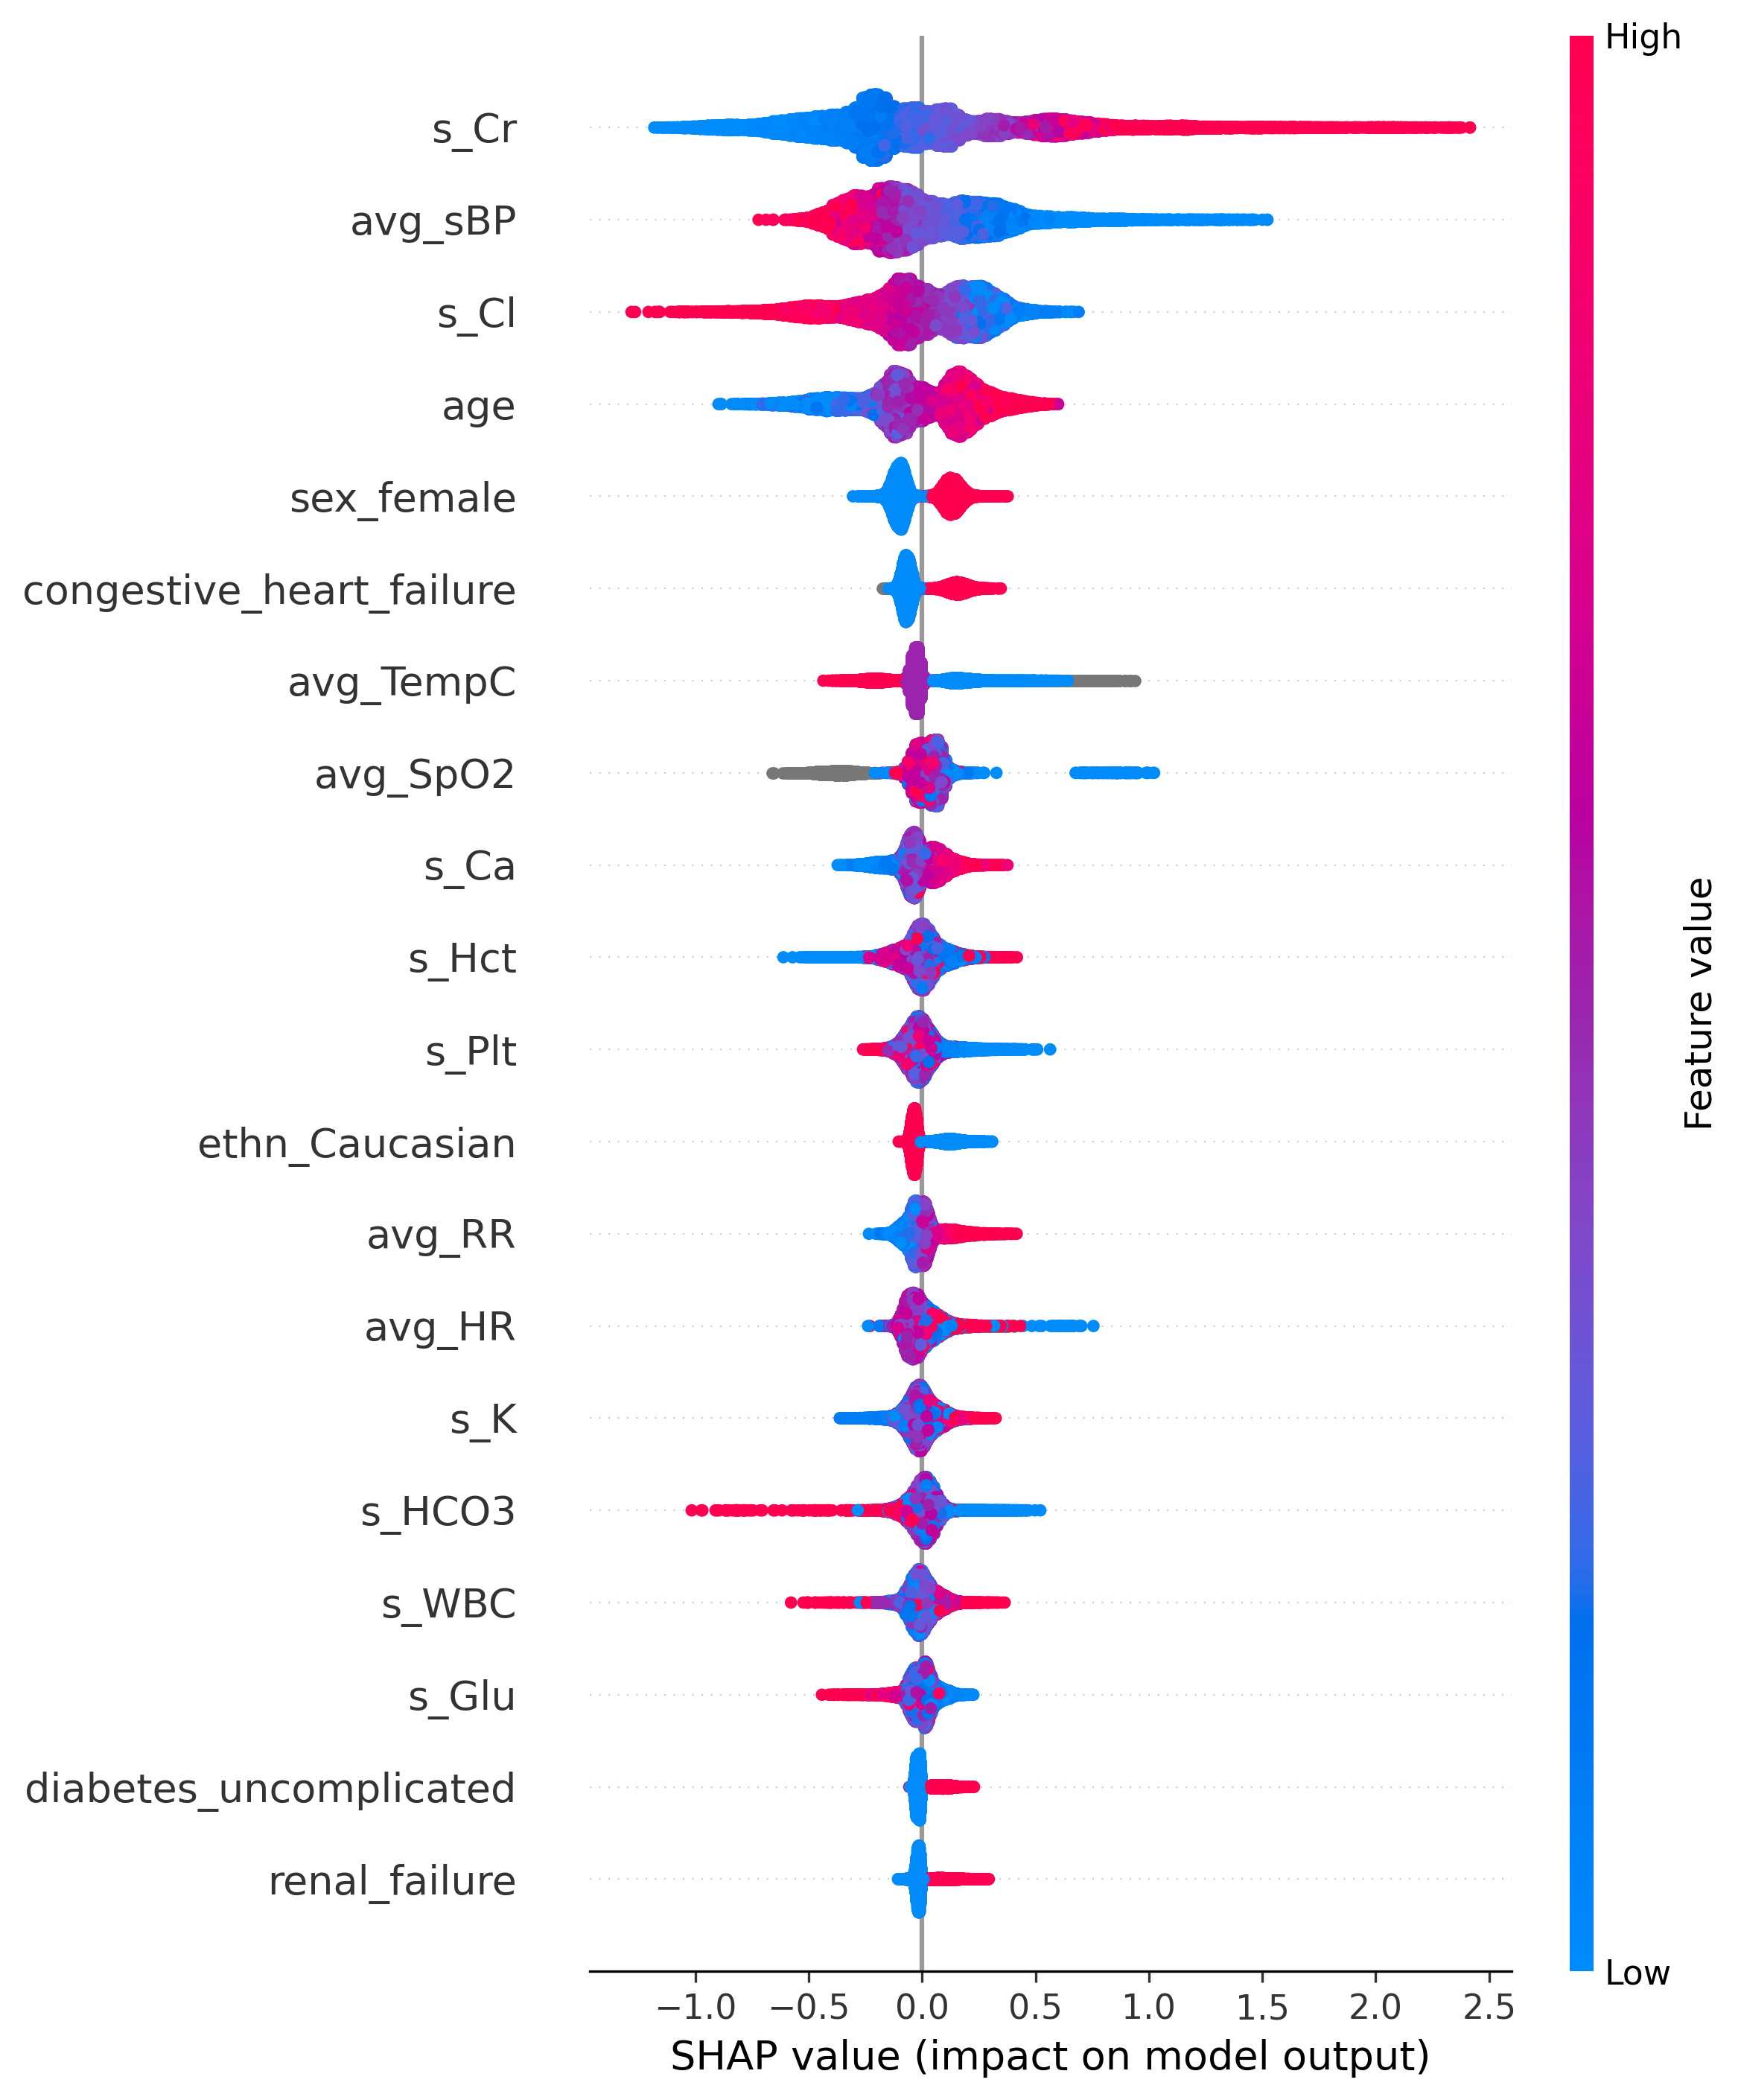

In [ ]:
# SHAP - https://www.kaggle.com/code/dansbecker/advanced-uses-of-shap-values
# https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137
rcParams['figure.figsize'] = 12, 4
rcParams['figure.dpi'] = 300.0
explainer = shap.TreeExplainer(X_model)
shap_values = explainer.shap_values(X_full)
shap.summary_plot(shap_values, X_full, color='white')

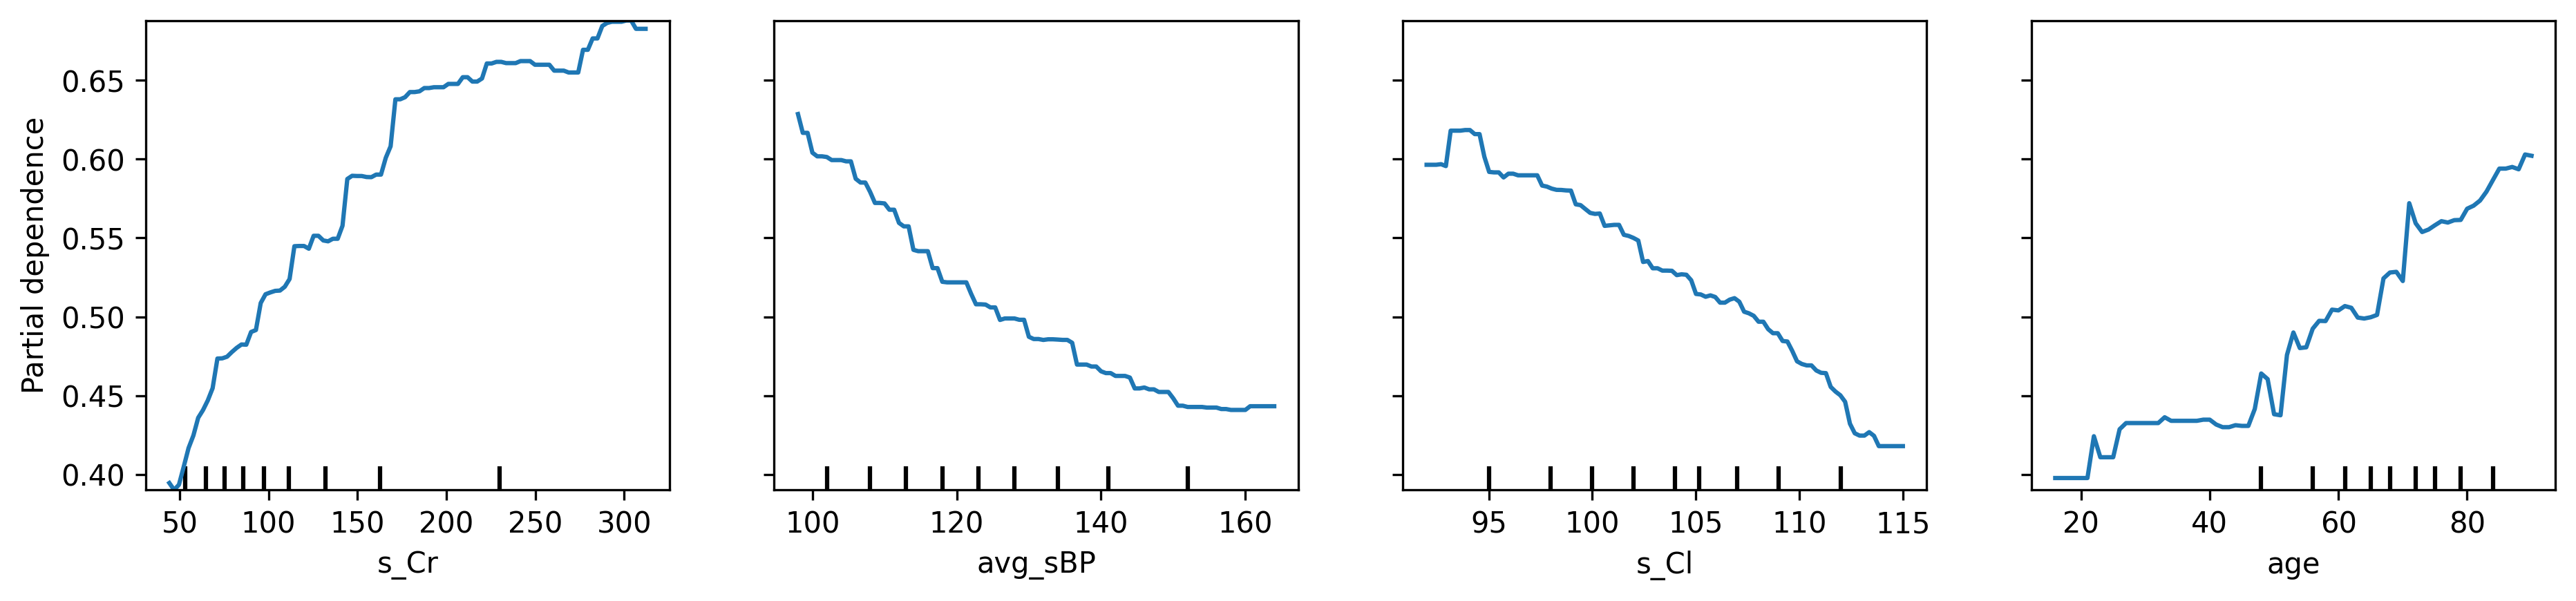

In [ ]:
# https://www.kaggle.com/code/dansbecker/partial-dependence-plots/notebook
# https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_partial_dependence_visualization_api.html
from sklearn.inspection import PartialDependenceDisplay

rcParams['figure.figsize'] = 15, 3
rcParams['figure.facecolor'] = 'white'
rcParams['figure.dpi'] = 300.0

pdp = PartialDependenceDisplay.from_estimator(X_model, X_full, ["s_Cr", "avg_sBP", "s_Cl", "age"], n_cols=4)

In [ ]:
X_full["s_Cr"].max()

1175.7426100000002

In [ ]:
rcParams['figure.figsize'] = 12, 4
explainer = shap.TreeExplainer(X_model,X_full)
shap_values = explainer.shap_values(X_full)
print("SHAP values ready")

100%|===================| 30747/30868 [03:54<00:00]       

SHAP values ready


In [ ]:
shap.plots.waterfall(shap_values)

AttributeError: ignored

# Individual model threshold tuning

In [ ]:
from sklearn.metrics import precision_recall_curve

#plt.style.use("ggplot")

def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]


def precision_recall_threshold(p, r, thresholds, t, y_scores, y_test):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    y_pred = adjusted_classes(y_scores, 0.5)
    y_prob_adj = adj_prob(y_scores, t)

    print("\nWithout threshold")
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))

    print("\nWith threshold")
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    cm = confusion_matrix(y_test, y_pred_adj) # get values to calculate sens/spec & LR's
    sn = cm[1,1]/(cm[1,1]+cm[1,0])
    sp = cm[0,0]/(cm[0,0]+cm[0,1])
    pl = sn/(1-sp)
    nl = (1-sn)/sp
    cm2 = confusion_matrix(y_test, y_pred) # get values to calculate sens/spec & LR's
    sn2 = cm2[1,1]/(cm2[1,1]+cm2[1,0])
    sp2 = cm2[0,0]/(cm2[0,0]+cm2[0,1])
    pl2 = sn2/(1-sp2)
    nl2 = (1-sn2)/sp2
    print(f"\n differences: TN={abs(cm[0,0]-cm2[0,0])}; TP={abs(cm[1,1]-cm2[1,1])}; FN={abs(cm[1,0]-cm2[1,0])}; FP={abs(cm[0,1]-cm2[0,1])}")
    print("\nCharacteristics (threshold vs. t=0.5)")
    print(f"  sens: {sn:.4f} vs. {sn2:.4f}")
    print(f"  spec: {sp:.4f} vs. {sp2:.4f}")
    print(f"   LR+: {pl:.4f} vs. {pl2:.4f}")
    print(f"   LR-: {nl:.4f} vs. {nl2:.4f}")

    print(f"\n{'MODEL REPORT (threshold vs. t=0.5)'}")
    print(f" {'Accuracy:':20} {metrics.accuracy_score(y_test.values, y_pred_adj):10.4f} vs. {metrics.accuracy_score(y_test.values, y_pred):.4f}")
    print(f" {'Precision:':20} {metrics.precision_score(y_test.values, y_pred_adj):10.4f} vs. {metrics.precision_score(y_test.values, y_pred):.4f}")
    print(f" {'Recall (sens):':20} {metrics.recall_score(y_test, y_pred_adj):10.4f} vs. {metrics.recall_score(y_test, y_pred):.4f}")
    print(f" {'F1 Score:':20} {metrics.f1_score(y_test.values, y_pred_adj):10.4f} vs. {metrics.f1_score(y_test.values, y_pred):.4f}")
    print(f" {'AUC:':20} {metrics.roc_auc_score(y_test.values, y_prob_adj):10.4f} vs. {metrics.roc_auc_score(y_test.values, y_scores):.4f}")

    # plot the curve
    plt.figure(figsize=(4,4))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    


    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)
    
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(4, 4))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')


Without threshold
     pred_neg  pred_pos
neg      1812      1114
pos      1051      2197

With threshold
     pred_neg  pred_pos
neg      2779       147
pos      2534       714

 differences: TN=967; TP=1483; FN=1483; FP=967

Characteristics (threshold vs. t=0.5)
  sens: 0.2198 vs. 0.6764
  spec: 0.9498 vs. 0.6193
   LR+: 4.3756 vs. 1.7767
   LR-: 0.8214 vs. 0.5225

MODEL REPORT (threshold vs. t=0.5)
 Accuracy:                0.5658 vs. 0.6493
 Precision:               0.8293 vs. 0.6635
 Recall (sens):           0.2198 vs. 0.6764
 F1 Score:                0.3475 vs. 0.6699
 AUC:                     0.6706 vs. 0.7173


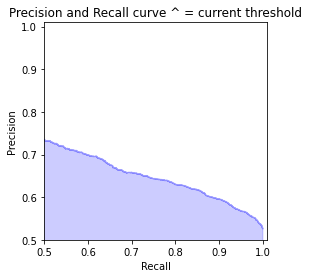

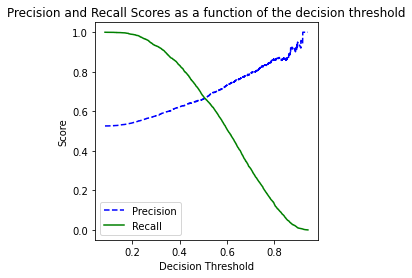

In [ ]:
#ypred_xgb_f1
#ypred_xgb_acc
#ypred_xgb_ran
#ypred_xgb_roc

#ypred_rfc_acc
#ypred_rfc_bri
#ypred_rfc_f1
#ypred_rfc_roc

ypred_xgb_roc = adj_prob(xgb_roc.predict_proba(X_xgb_roc_)[:,1], t=0.5)

threshold = 0.75
ypred = ypred_xgb_roc
yreal = y_test_.copy() # y_test
# use pr0 (y_train), pr1 (y_test), pr2 (y__test) generated above

p, r, thresholds = precision_recall_curve(yreal, ypred) # use pr0 (y_train), pr1 (y_test), pr2 (y__test) generated above
precision_recall_threshold(p, r, thresholds, threshold, ypred, yreal)
plot_precision_recall_vs_threshold(p, r, thresholds)

# MIMIC (validate)

In [ ]:
# get probabilities from models
ypred_xgb_f1 = adj_prob(xgb_f1.predict_proba(X__xgb_f1)[:,1], t=0.5) # 0.9
ypred_xgb_acc = adj_prob(xgb_acc.predict_proba(X__xgb_acc)[:,1], t=0.5) # 0.5
ypred_xgb_ran = adj_prob(xgb_rando.predict_proba(X__xgb_ran)[:,1], t=0.5) # 0.5
ypred_xgb_roc = adj_prob(xgb_roc.predict_proba(X__xgb_roc)[:,1], t=0.5) # 0.5

#ypred_rfc_acc = adj_prob(rfc_acc.predict_proba(X__rfc)[:,1], t=0.5)
#ypred_rfc_bri = adj_prob(rfc_brier.predict_proba(X__rfc)[:,1], t=0.6)
#ypred_rfc_f1 = adj_prob(rfc_f1.predict_proba(X__rfc)[:,1], t=0.6)
#ypred_rfc_roc = adj_prob(rfc_roc.predict_proba(X__rfc)[:,1], t=0.6)


# average of the probabilities (arithmetic mean)
#ypredprob_arr_mean = [(aa+bb+cc+dd+ee+ff+gg+hh) / num_models for aa, bb, cc, dd, ee, ff, gg, hh in 
#                      zip(ypred_xgb_f1, ypred_xgb_acc, ypred_xgb_ran, ypred_xgb_roc,
#                          ypred_rfc_acc, ypred_rfc_bri, ypred_rfc_f1, ypred_rfc_roc)] 

# average of the probabilities (geometric mean) -> Power(1/n) of (x1*x2*...*xn)
#ypredprob_geo_mean = [(aa*bb*cc*dd*ee*ff*gg*hh)**(1/num_models) for aa, bb, cc, dd, ee, ff, gg, hh in 
#                      zip(ypred_xgb_f1, ypred_xgb_acc, ypred_xgb_ran, ypred_xgb_roc,
#                          ypred_rfc_acc, ypred_rfc_bri, ypred_rfc_f1, ypred_rfc_roc)]


# average of the probabilities (arithmetic mean)
ypredprob_arr_mean = [(aa+bb+cc+dd) / num_models for aa, bb, cc, dd in zip(ypred_xgb_f1, ypred_xgb_acc, ypred_xgb_ran, ypred_xgb_roc)] 

# average of the probabilities (geometric mean) -> Power(1/n) of (x1*x2*...*xn)
ypredprob_geo_mean = [(aa*bb*cc*dd)**(1/num_models) for aa, bb, cc, dd in zip(ypred_xgb_f1, ypred_xgb_acc, ypred_xgb_ran, ypred_xgb_roc)]


# can consider using strong models twice, etc. to test different combinations

print(f"{'   mod 1':10}{'   mod 2':10}{'   mod 3':10}{'   mod 4':10}{'   mod 5':10}{'   mod 6':10}{'   mod 7':10}{'   mod 8':10}{'   arr_avg':10}{'   geo_avg':10}")
for i in range(0,10):
  print(f"{ypred_xgb_f1[i]:10.4f}{ypred_xgb_acc[i]:10.4f}{ypred_xgb_ran[i]:10.4f}{ypred_xgb_roc[i]:10.4f}",
        #f"{ypred_rfc_acc[i]:10.4f}{ypred_rfc_bri[i]:10.4f}{ypred_rfc_f1[i]:10.4f}{ypred_rfc_roc[i]:10.4f}",
        f"{ypredprob_arr_mean[i]:10.4f}{ypredprob_geo_mean[i]:10.4f}")

   mod 1     mod 2     mod 3     mod 4     mod 5     mod 6     mod 7     mod 8     arr_avg   geo_avg
    0.2799    0.2932    0.2855    0.3160     0.2937    0.2933
    0.3109    0.4075    0.3987    0.3408     0.3645    0.3622
    0.3773    0.3752    0.4299    0.3499     0.3831    0.3820
    0.3705    0.4200    0.4452    0.3779     0.4034    0.4023
    0.3488    0.4467    0.4676    0.3809     0.4110    0.4082
    0.3317    0.3616    0.3593    0.3344     0.3467    0.3465
    0.4943    0.4569    0.4166    0.4575     0.4563    0.4555
    0.7885    0.7645    0.6872    0.7616     0.7505    0.7495
    0.2946    0.3408    0.3067    0.2737     0.3039    0.3030
    0.3378    0.4538    0.3784    0.3722     0.3855    0.3833


 Arr. Mean:

MODEL REPORT              
 Accuracy:                     0.5995
 Precision:                    0.7765
 Recall (sensitivity):         0.2827
 F1 Score:                     0.4144
 AUC Score:                    0.6898

                | Pred NoRes | Pred LDR  
True No Res     |       5800 |        517
True LDR        |       4558 |       1796

Characteristics
  sens: 0.282657
  spec: 0.918157
   ppv: 0.776481
   npv: 0.559954
   LR+: 3.453659
   LR-: 0.781286


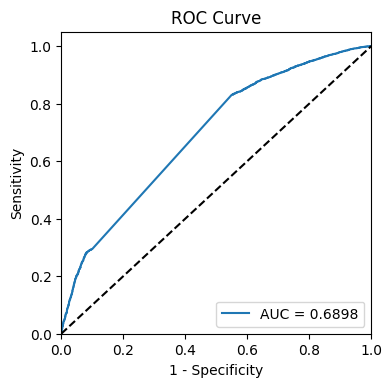


 Geo. Mean
threshold: 0.785

MODEL REPORT              
 Accuracy:                     0.5990
 Precision:                    0.7766
 Recall (sensitivity):         0.2812
 F1 Score:                     0.4129
 AUC Score:                    0.6902

                | Pred NoRes | Pred LDR  
True No Res     |       5803 |        514
True LDR        |       4567 |       1787

Characteristics
  sens: 0.281240
  spec: 0.918632
   ppv: 0.776619
   npv: 0.559595
   LR+: 3.456409
   LR-: 0.782424


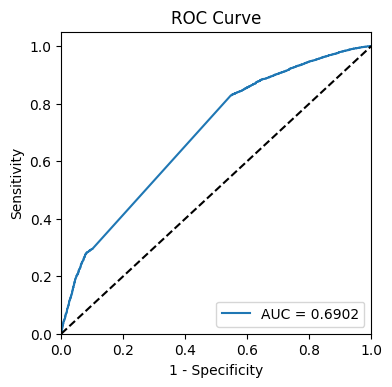

In [ ]:
THRESH = 0.785

print(" Arr. Mean:")
#ypred, ypred_prob = [1 if y >= THRESH else 0 for y in ypredprob_arr_mean], ypredprob_arr_mean
ypred, ypred_prob = [1 if y >= THRESH else 0 for y in ypredprob_arr_mean], [0.49 if (y >= 0.5 and y < THRESH) else y for y in ypredprob_arr_mean]
        
#Print model report:
print(f"\n{'MODEL REPORT':26}")
print(f" {'Accuracy:':25} {metrics.accuracy_score(y__test.values, ypred):10.4f}")
print(f" {'Precision:':25} {metrics.precision_score(y__test.values, ypred):10.4f}")
print(f" {'Recall (sensitivity):':25} {metrics.recall_score(y__test, ypred):10.4f}")
print(f" {'F1 Score:':25} {metrics.f1_score(y__test.values, ypred):10.4f}")
print(f" {'AUC Score:':25} {metrics.roc_auc_score(y__test.values, ypred_prob):10.4f}")

cm = confusion_matrix(y__test, ypred) # get values to calculate sens/spec & LR's

print(f"\n{'':15} | {'Pred NoRes':10} | {'Pred LDR':10}")
print(f"{'True No Res':15} | {cm[0,0]:10} | {cm[0,1]:10}")
print(f"{'True LDR':15} | {cm[1,0]:10} | {cm[1,1]:10}")

sn = cm[1,1]/(cm[1,1]+cm[1,0]) # Sens = TP / (TP + FN)
sp = cm[0,0]/(cm[0,0]+cm[0,1]) # Spec = TN / (FP + TN)
ppv = cm[1,1]/(cm[1,1]+cm[0,1]) # PPV = TP / (TP + FP)
npv = cm[0,0]/(cm[0,0]+cm[1,0])# NPV = TN / (FN + TN)
pl = sn/(1-sp)
nl = (1-sn)/sp
print("\nCharacteristics")
print("  sens: %f" % sn)
print("  spec: %f" % sp)
print("   ppv: %f" % ppv)
print("   npv: %f" % npv)
print("   LR+: %f" % pl)
print("   LR-: %f" % nl)

rcParams['figure.figsize'] = 4, 4
    # Perforamnce of the model
fpr, tpr, _ = roc_curve(y__test.values, ypred_prob)
AUC  = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='AUC = %0.4f' % AUC)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


print("\n Geo. Mean")
print(f"threshold: {THRESH}")
#ypred, ypred_prob = [1 if y >= THRESH else 0 for y in ypredprob_geo_mean], ypredprob_geo_mean
ypred, ypred_prob = [1 if y >= THRESH else 0 for y in ypredprob_geo_mean], [0.49 if (y >= 0.5 and y < THRESH) else y for y in ypredprob_geo_mean] 

#Print model report:
print(f"\n{'MODEL REPORT':26}")
print(f" {'Accuracy:':25} {metrics.accuracy_score(y__test.values, ypred):10.4f}")
print(f" {'Precision:':25} {metrics.precision_score(y__test.values, ypred):10.4f}")
print(f" {'Recall (sensitivity):':25} {metrics.recall_score(y__test, ypred):10.4f}")
print(f" {'F1 Score:':25} {metrics.f1_score(y__test.values, ypred):10.4f}")
print(f" {'AUC Score:':25} {metrics.roc_auc_score(y__test.values, ypred_prob):10.4f}")

cm = confusion_matrix(y__test, ypred) # get values to calculate sens/spec & LR's

print(f"\n{'':15} | {'Pred NoRes':10} | {'Pred LDR':10}")
print(f"{'True No Res':15} | {cm[0,0]:10} | {cm[0,1]:10}")
print(f"{'True LDR':15} | {cm[1,0]:10} | {cm[1,1]:10}")

sn = cm[1,1]/(cm[1,1]+cm[1,0]) # Sens = TP / (TP + FN)
sp = cm[0,0]/(cm[0,0]+cm[0,1]) # Spec = TN / (FP + TN)
ppv = cm[1,1]/(cm[1,1]+cm[0,1]) # PPV = TP / (TP + FP)
npv = cm[0,0]/(cm[0,0]+cm[1,0])# NPV = TN / (FN + TN)
pl = sn/(1-sp)
nl = (1-sn)/sp
print("\nCharacteristics")
print("  sens: %f" % sn)
print("  spec: %f" % sp)
print("   ppv: %f" % ppv)
print("   npv: %f" % npv)
print("   LR+: %f" % pl)
print("   LR-: %f" % nl)

rcParams['figure.figsize'] = 4, 4
    # Perforamnce of the model
fpr, tpr, _ = roc_curve(y__test.values, ypred_prob)
AUC  = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='AUC = %0.4f' % AUC)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# MIMIC calibration

In [ ]:
print("\n Geo. Mean Calibration - MIMIC")

print("AUC:")
print("sens:")
print("spec:")
print("ppv:")
print("npv:")
print("LR+:")
print("LR-:")

for i in [0.5,0.6,0.7,0.73,0.75,0.76,0.77,0.78,0.79,0.8,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.90,0.91]:
  ypred, ypred_prob = [1 if y >= i else 0 for y in ypredprob_geo_mean], [0.49 if (y >= 0.5 and y < i) else y for y in ypredprob_geo_mean] 
  cm = confusion_matrix(y__test, ypred) # get values to calculate sens/spec & LR's
  sn = cm[1,1]/(cm[1,1]+cm[1,0]) # Sens = TP / (TP + FN)
  sp = cm[0,0]/(cm[0,0]+cm[0,1]) # Spec = TN / (FP + TN)
  ppv = cm[1,1]/(cm[1,1]+cm[0,1]) # PPV = TP / (TP + FP)
  npv = cm[0,0]/(cm[0,0]+cm[1,0])# NPV = TN / (FN + TN)
  pl = sn/(1-sp)
  nl = (1-sn)/sp
  print(f"\nTHRESHOLD: {i}")
  print(f"{metrics.roc_auc_score(y__test.values, ypred_prob):10.4f}")
  print(f"{sn:10.4f}")
  print(f"{sp:10.4f}")
  print(f"{ppv:10.4f}")
  print(f"{npv:10.4f}")
  print(f"{pl:10.4f}")
  print(f"{nl:10.4f}")


 Geo. Mean Calibration - MIMIC
AUC:
sens:
spec:
ppv:
npv:
LR+:
LR-:

THRESHOLD: 0.5
    0.7165
    0.8143
    0.4727
    0.6083
    0.7168
    1.5442
    0.3929

THRESHOLD: 0.6
    0.7153
    0.6602
    0.6672
    0.6662
    0.6613
    1.9841
    0.5092

THRESHOLD: 0.7
    0.7043
    0.4509
    0.8208
    0.7168
    0.5978
    2.5162
    0.6690

THRESHOLD: 0.73
    0.7008
    0.3936
    0.8594
    0.7380
    0.5849
    2.8000
    0.7056

THRESHOLD: 0.75
    0.6964
    0.3492
    0.8819
    0.7484
    0.5740
    2.9572
    0.7379

THRESHOLD: 0.76
    0.6950
    0.3311
    0.8927
    0.7563
    0.5702
    3.0852
    0.7493

THRESHOLD: 0.77
    0.6934
    0.3135
    0.9023
    0.7635
    0.5665
    3.2097
    0.7608

THRESHOLD: 0.78
    0.6912
    0.2923
    0.9129
    0.7715
    0.5619
    3.3567
    0.7752

THRESHOLD: 0.79
    0.6891
    0.2709
    0.9237
    0.7812
    0.5574
    3.5497
    0.7894

THRESHOLD: 0.8
    0.6866
    0.2515
    0.9315
    0.7868
    0.5530
    3.6690
    0.

# Grid Search



In [ ]:
# eICU (test set)

best_score_arr = [0.1,0.]
best_score_geo = [0.1,0.]

y_test=[] # remove if testing all eICU
y_test=y_test_.copy() # remove if testing all eICU


for i in [0.5,0.6,0.7,0.8,0.9]:
  ypred_xgb_f1 = adj_prob(xgb_f1.predict_proba(X_xgb_f1_)[:,1], t=0.5) #t=0.5
  ypred_xgb_acc = adj_prob(xgb_acc.predict_proba(X_xgb_acc_)[:,1], t=0.5) #t=0.8
  ypred_xgb_ran = adj_prob(xgb_rando.predict_proba(X_xgb_ran_)[:,1], t=0.5) #t=0.9
  ypred_xgb_roc = adj_prob(xgb_roc.predict_proba(X_xgb_roc_)[:,1], t=i) #t=0.6

  #ypred_rfc_acc = adj_prob(rfc_acc.predict_proba(X_rfc_)[:,1], t=0.5) #t=0.5
  #ypred_rfc_bri = adj_prob(rfc_brier.predict_proba(X_rfc_)[:,1], t=0.5) #t=0.8
  #ypred_rfc_f1 = adj_prob(rfc_f1.predict_proba(X_rfc_)[:,1], t=0.5) #t=0.5
  #ypred_rfc_roc = adj_prob(rfc_roc.predict_proba(X_rfc_)[:,1], t=i) #t=0.5

  # average of the probabilities (arithmetic mean)
  #ypredprob_arr_mean = [(aa+bb+cc+dd+ee+ff+gg+hh) / num_models for aa, bb, cc, dd, ee, ff, gg, hh in 
  #                    zip(ypred_xgb_f1, ypred_xgb_acc, ypred_xgb_ran, ypred_xgb_roc,
  #                        ypred_rfc_acc, ypred_rfc_bri, ypred_rfc_f1, ypred_rfc_roc)] 

  # average of the probabilities (geometric mean) -> Power(1/n) of (x1*x2*...*xn)
  #ypredprob_geo_mean = [(aa*bb*cc*dd*ee*ff*gg*hh)**(1/num_models) for aa, bb, cc, dd, ee, ff, gg, hh in 
  #                    zip(ypred_xgb_f1, ypred_xgb_acc, ypred_xgb_ran, ypred_xgb_roc,
  #                        ypred_rfc_acc, ypred_rfc_bri, ypred_rfc_f1, ypred_rfc_roc)]

  # average of the probabilities (arithmetic mean)
  ypredprob_arr_mean = [(aa+bb+cc+dd) / num_models for aa, bb, cc, dd in zip(ypred_xgb_f1, ypred_xgb_acc, ypred_xgb_ran, ypred_xgb_roc)] 

  # average of the probabilities (geometric mean) -> Power(1/n) of (x1*x2*...*xn)
  ypredprob_geo_mean = [(aa*bb*cc*dd)**(1/num_models) for aa, bb, cc, dd in zip(ypred_xgb_f1, ypred_xgb_acc, ypred_xgb_ran, ypred_xgb_roc)]


  auc_arr = metrics.roc_auc_score(y_test.values, ypredprob_arr_mean)
  auc_geo = metrics.roc_auc_score(y_test.values, ypredprob_geo_mean)

  print(f"t={i}, AUC: arr={auc_arr:.6f}, geo={auc_geo:.6f}")

  if auc_arr > best_score_arr[0]:
    best_score_arr[0] = auc_arr
    best_score_arr[1] = i

  if auc_geo > best_score_geo[0]:
    best_score_geo[0] = auc_geo
    best_score_geo[1] = i

print(f"Best arr={best_score_arr[0]}, t={best_score_arr[1]}")
print(f"Best geo={best_score_geo[0]}, t={best_score_geo[1]}")

t=0.5, AUC: arr=0.716595, geo=0.716671
t=0.6, AUC: arr=0.716724, geo=0.716815
t=0.7, AUC: arr=0.715394, geo=0.715368
t=0.8, AUC: arr=0.715302, geo=0.715286
t=0.9, AUC: arr=0.715010, geo=0.714979
Best arr=0.7167237254578451, t=0.6
Best geo=0.7168149535841395, t=0.6


In [ ]:
# MIMIC

best_score_arr = [0.1,0.]
best_score_geo = [0.1,0.]

for i in [0.5,0.6,0.7,0.8,0.9]:
  ypred_xgb_f1 = adj_prob(xgb_f1.predict_proba(X__xgb_f1)[:,1], t=0.5) #t=0.9
  ypred_xgb_acc = adj_prob(xgb_acc.predict_proba(X__xgb_acc)[:,1], t=0.5) #t=0.5
  ypred_xgb_ran = adj_prob(xgb_rando.predict_proba(X__xgb_ran)[:,1], t=0.5) #t=0.5
  ypred_xgb_roc = adj_prob(xgb_roc.predict_proba(X__xgb_roc)[:,1], t=0.5) #t=0.5

  #ypred_rfc_acc = adj_prob(rfc_acc.predict_proba(X__rfc)[:,1], t=0.5) #t=0.5
  #ypred_rfc_bri = adj_prob(rfc_brier.predict_proba(X__rfc)[:,1], t=0.5) #t=0.6
  #ypred_rfc_f1 = adj_prob(rfc_f1.predict_proba(X__rfc)[:,1], t=0.5) #t=0.6
  #ypred_rfc_roc = adj_prob(rfc_roc.predict_proba(X__rfc)[:,1], t=i) #t=0.6

  # average of the probabilities (arithmetic mean)
  #ypredprob_arr_mean = [(aa+bb+cc+dd+ee+ff+gg+hh) / num_models for aa, bb, cc, dd, ee, ff, gg, hh in 
  #                    zip(ypred_xgb_f1, ypred_xgb_acc, ypred_xgb_ran, ypred_xgb_roc,
  #                        ypred_rfc_acc, ypred_rfc_bri, ypred_rfc_f1, ypred_rfc_roc)] 

  # average of the probabilities (geometric mean) -> Power(1/n) of (x1*x2*...*xn)
  #ypredprob_geo_mean = [(aa*bb*cc*dd*ee*ff*gg*hh)**(1/num_models) for aa, bb, cc, dd, ee, ff, gg, hh in 
  #                    zip(ypred_xgb_f1, ypred_xgb_acc, ypred_xgb_ran, ypred_xgb_roc,
  #                        ypred_rfc_acc, ypred_rfc_bri, ypred_rfc_f1, ypred_rfc_roc)]

  # average of the probabilities (arithmetic mean)
  ypredprob_arr_mean = [(aa+bb+cc+dd) / num_models for aa, bb, cc, dd in zip(ypred_xgb_f1, ypred_xgb_acc, ypred_xgb_ran, ypred_xgb_roc)] 

  # average of the probabilities (geometric mean) -> Power(1/n) of (x1*x2*...*xn)
  ypredprob_geo_mean = [(aa*bb*cc*dd)**(1/num_models) for aa, bb, cc, dd in zip(ypred_xgb_f1, ypred_xgb_acc, ypred_xgb_ran, ypred_xgb_roc)]

  auc_arr = metrics.roc_auc_score(y__test.values, ypredprob_arr_mean)
  auc_geo = metrics.roc_auc_score(y__test.values, ypredprob_geo_mean)

  print(f"t={i}, AUC: arr={auc_arr:.6f}, geo={auc_geo:.6f}")

  if auc_arr > best_score_arr[0]:
    best_score_arr[0] = auc_arr
    best_score_arr[1] = i

  if auc_geo > best_score_geo[0]:
    best_score_geo[0] = auc_geo
    best_score_geo[1] = i

print(f"Best arr={best_score_arr[0]}, t={best_score_arr[1]}")
print(f"Best geo={best_score_geo[0]}, t={best_score_geo[1]}")

t=0.5, AUC: arr=0.713719, geo=0.713722
t=0.6, AUC: arr=0.713134, geo=0.713005
t=0.7, AUC: arr=0.712847, geo=0.712658
t=0.8, AUC: arr=0.713405, geo=0.713264
t=0.9, AUC: arr=0.713637, geo=0.713507
Best arr=0.7137194406587756, t=0.5
Best geo=0.7137221313611879, t=0.5
